In [15]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from lazypredict.Supervised import LazyClassifier, LazyRegressor

import glob

from IPython.core.display import HTML

In [2]:
deceptive_files = glob.glob('./Deceptive/*.txt')
dfs = []

for file in deceptive_files:
    with open(file, 'r', encoding='utf-8') as f:
        text = f.read()
        lines = f.readlines()
        dfs.append([text, 0])

deceptive_df = pd.DataFrame(dfs, columns=['Statement', 'Is_Truth'])

In [3]:
truthful_files = glob.glob('./Truthful/*.txt')
dfs = []

for file in truthful_files:
    with open(file, 'r', encoding='utf-8') as f:
        text = f.read()
        lines = f.readlines()
        dfs.append([text, 1])

truthful_df = pd.DataFrame(dfs, columns=['Statement', 'Is_Truth'])

In [4]:
combined_df = pd.concat([deceptive_df, truthful_df])

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [6]:
def tokenize(text):
    try:
        output = tokenizer.encode_plus(text, add_special_tokens = True, max_length = 64, pad_to_max_length = True, return_attention_mask = True, return_tensors = 'pt')
        return (output['input_ids'], output['attention_mask'])
    except:
        return None

In [7]:
input_ids = []
attention_masks = []

for x in combined_df['Statement']:
    tkns = tokenize(x)
    input_ids.append(tkns[0])
    attention_masks.append(tkns[1])

combined_df['input_ids'] = input_ids
combined_df['attention_masks'] = attention_masks

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\users\abish\appdata\local\programs\python\python39\lib\site-packages\transformers\tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [8]:
tensor_df = TensorDataset(torch.cat(list(combined_df['input_ids'])), torch.cat(list(combined_df['attention_masks'])), torch.tensor(list(combined_df['Is_Truth'])))

In [9]:
train_size = int(0.9 * len(tensor_df))
test_size = len(tensor_df) - train_size

train_dataset, test_dataset = random_split(tensor_df, [train_size, test_size])

In [10]:
batch_size = 32

train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-5, eps=1e-8)

In [11]:
model.eval()

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

true_labels = []
pred_labels = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    input_ids, attention_mask, labels = batch
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        logits = logits.detach().cpu().numpy()
        labels = labels.to('cpu').numpy()
        
        true_labels.extend(labels)
        pred_labels.extend(np.argmax(logits, axis=1).flatten())

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.5385
Precision: 0.2899
Recall: 0.5385
F1 Score: 0.3769


c:\users\abish\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


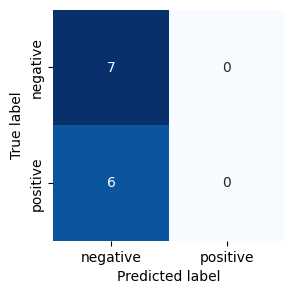

In [14]:
# Define the label names
label_names = ['negative', 'positive']

# Create a dictionary that maps label ids to label names
labels_map = {i: label_name for i, label_name in enumerate(label_names)}

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, square=True, 
            xticklabels=labels_map.values(), yticklabels=labels_map.values())
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [43]:
x = pd.DataFrame(tokenizer.convert_ids_to_tokens(x) for x in combined_df['input_ids'])
X_train, X_test, y_train, y_test = train_test_split(x, combined_df['Is_Truth'], test_size=.2, random_state=42)
    
clf = LazyClassifier(predictions=True)
models, predictions = clf.fit(pd.DataFrame(X_train), pd.DataFrame(X_test), pd.DataFrame(Y_train), pd.DataFrame(Y_test))

ValueError: only one element tensors can be converted to Python scalars

In [31]:
train_dataset[0][1].tolist()

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [39]:
Y_train

[[1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 [1,
  1,
  1,
  1,
  1,
  1,
  1,
  

In [37]:
predictions

""
